In [1]:
import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "0,1" for multiple GPUs
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import pandas as pd
from tqdm import tqdm

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
# nltk.download('stopwords')
# nltk.download('wordnet')
stop_words = stopwords.words('english')
from sklearn.preprocessing import LabelEncoder

sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    
    text = text.lower()
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,' ') #Removing punctuations
    
    # pattern = r"\b(?=[mdclxviι])m{0,4}(cm|cd|d?c{0,3})(xc|xl|l?x{0,3})([iι]x|[iι]v|v?[iι]{0,3})\b\.?"
    # text =  re.sub(pattern, ' ', text.lower())

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

with open('training.json', 'r') as file:
  first_line = file.readline()
  df = pd.read_json(file, lines=True)

# remove heading 'map'
df = df[df["heading"] != "map"]

df['heading'] = df['heading'].apply(lambda x: clean_text(x))

df['sentence'] = df.apply(lambda row: f"{row['section']} {row['heading']}", axis=1)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])

In [5]:
df['section'].unique()

array(['for-sale', 'housing', 'community', 'services'], dtype=object)

In [242]:
df_general  = df[df["category"] == "general"]
df_general.shape

(872, 6)

In [244]:
m = df.groupby(['category']).size()
m = m.sort_values()

In [245]:
n_samples = len(df_general.values)

In [246]:
catcat = []
for i in range(len(m)):
    if m[i] >= n_samples:
        # print(mm)
        catcat.append(m.index[i])

print(len(catcat))

13


In [247]:
df_1000_over = df.loc[df['category'].isin(catcat)]

In [ ]:
#downsample
from sklearn.utils import resample
list_df_ds = []
for cc in catcat:
    df_downsample_ = resample(df[df['category']==cc],
                replace=True,
                n_samples=n_samples,
                random_state=42)
    list_df_ds.append(df_downsample_)

# print(df_downsample.shape)
cat = []
for i in range(len(m)):
    if m[i] < n_samples:
        # print(m[i])
        cat.append(m.index[i])

print(cat)

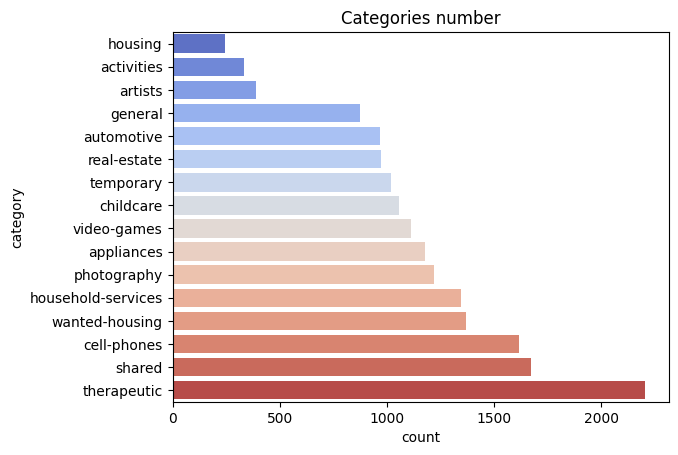

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns

num_colors = 16
palette = sns.color_palette("coolwarm", num_colors)

sns.barplot(x=m.values, y=m.index, palette=palette, hue=m.index)
plt.xlabel('count')
plt.title('Categories number')
plt.xticks(rotation=0)
plt.show()

In [251]:
df_1000_under = df.loc[df['category'].isin(cat)]

In [252]:
df_1000_under['category'].unique()

array(['housing', 'activities', 'artists'], dtype=object)

In [257]:
df_ds = pd.concat(list_df_ds)

In [305]:
len(df_ds['category'].unique())

13

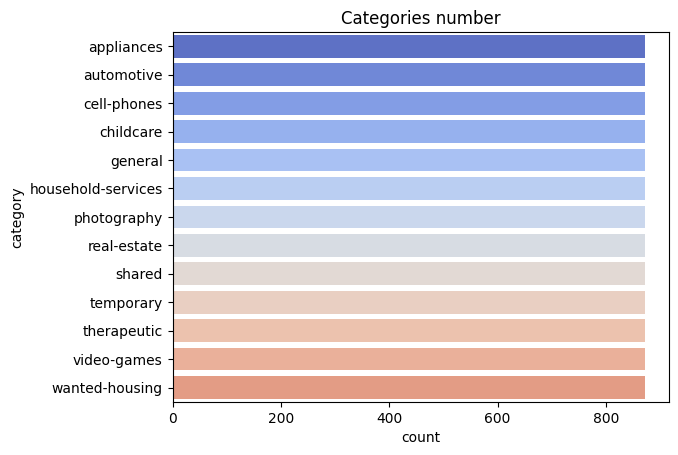

In [306]:
import matplotlib.pyplot as plt
import seaborn as sns

m = df_ds.groupby(['category']).size()
m = m.sort_values()


num_colors = 16
palette = sns.color_palette("coolwarm", num_colors)

sns.barplot(x=m.values, y=m.index, palette=palette, hue=m.index)
plt.xlabel('count')
plt.title('Categories number')
plt.xticks(rotation=0)
plt.show()

In [307]:
df_1000_under.head()

,city,category,section,heading,sentence,label
1563,newyork,housing,housing,th st east full size bdrm low fee avail,housing th st east full size bdrm low fee avail,8
1564,newyork,housing,housing,great share xl bed lot privacy hot loc low fee,housing great share xl bed lot privacy hot loc...,8
1565,newyork,housing,housing,e nd real br oct rd sizzling deal,housing e nd real br oct rd sizzling deal,8
1566,newyork,housing,housing,cute couple lg br pwar great value low fee,housing cute couple lg br pwar great value low...,8
1569,newyork,housing,housing,amazing br prime west village location,housing amazing br prime west village location,8


In [258]:
df = pd.concat([df_1000_under, df_ds])

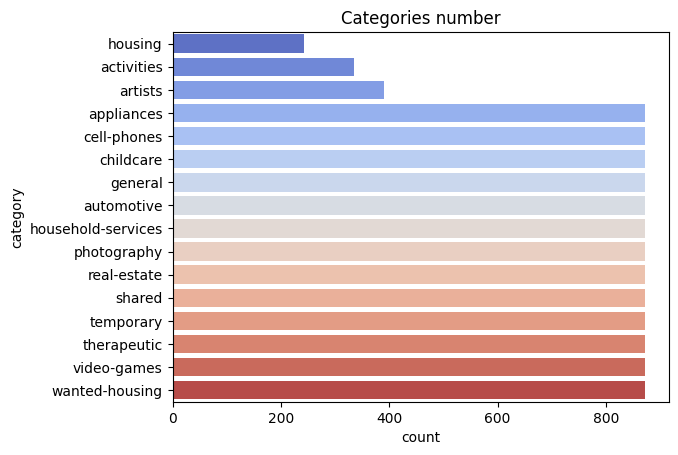

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns

m = df.groupby(['category']).size()
m = m.sort_values()

num_colors = 16
palette = sns.color_palette("coolwarm", num_colors)

sns.barplot(x=m.values, y=m.index, palette=palette, hue=m.index)
plt.xlabel('count')
plt.title('Categories number')
plt.xticks(rotation=0)
plt.show()

In [262]:
new_tokens = []
for sec in df['city'].values:
  new_tokens.append(sec)
for sec in df['section'].values:
  new_tokens.append(sec)
  
id_list = [int(x) for x in sorted(df['label'].unique())]
id2label = dict(zip(id_list, sorted(df['category'].unique())))
label2id = dict(zip(sorted(df['category'].unique()), id_list))

df = df[['sentence', 'label']]

In [3]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df, preserve_index=True)

from transformers import AutoTokenizer
checkpoint = 'distilbert/distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

new_tokens = set(new_tokens) - set(tokenizer.vocab.keys())
tokenizer.add_tokens(list(new_tokens))

def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation = True)

# raw_dataset = raw_dataset.class_encode_column("label")
split = raw_dataset.train_test_split(test_size=0.3, seed=42)
tokenized_dataset = split.map(tokenize_fn, batched = True)

# tokenized_dataset.remove_columns(["__index_level_0__"])

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# from torchinfo import summary
# summary(model)

ModuleNotFoundError: No module named 'datasets'

In [269]:
model = AutoModelForSequenceClassification.from_pretrained(
  checkpoint, num_labels = len(df['label'].unique()), id2label=id2label, label2id=label2id)

model.resize_token_embeddings(len(tokenizer))

training_args = TrainingArguments(output_dir='training_dir',
                                  overwrite_output_dir=True,
                                  num_train_epochs=10.0,
                                  learning_rate=1e-5,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  dataloader_num_workers=1,
                                  dataloader_prefetch_factor=2,
                                  # weight_decay=0.01,
                                  # logging_steps=100,
                                  disable_tqdm=False,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                    # log_level="error"
                                  )

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)
trainer.train()
# trainer.save_model("saved_model")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,1.461000,0.668722,0.796046,0.796046
2,0.591400,0.461066,0.845612,0.845612
3,0.419400,0.390623,0.868093,0.868093
4,0.305500,0.363257,0.876490,0.876490
5,0.233600,0.368018,0.886511,0.886511
6,0.181000,0.352592,0.897616,0.897616
7,0.151000,0.365412,0.900596,0.900596
8,0.123100,0.373234,0.904388,0.904388
9,0.114100,0.379692,0.907638,0.907638
10,0.088700,0.384784,0.907367,0.907367


TrainOutput(global_step=5390, training_loss=0.346613107231862, metrics={'train_runtime': 760.3079, 'train_samples_per_second': 113.283, 'train_steps_per_second': 7.089, 'total_flos': 363416186631360.0, 'train_loss': 0.346613107231862, 'epoch': 10.0})

In [270]:
trainer.save_model("save_model_4")

In [2]:
from transformers import pipeline

model_load = pipeline("text-classification", model='saved_model')

d:\Anaconda3\envs\gpt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [285]:
y_pred = model_load.predict(tokenized_dataset['test']['sentence'])

In [81]:
label2id

{'activities': 0,
 'appliances': 1,
 'artists': 2,
 'automotive': 3,
 'cell-phones': 4,
 'childcare': 5,
 'general': 6,
 'household-services': 7,
 'housing': 8,
 'photography': 9,
 'real-estate': 10,
 'shared': 11,
 'temporary': 12,
 'therapeutic': 13,
 'video-games': 14,
 'wanted-housing': 15}

In [223]:
model_load.predict('singapore for-sale playstation , price reduced')

[{'label': 'video-games', 'score': 0.990825355052948}]

In [293]:
y_pred_id = []

for pred in y_pred:
    y_pred_id.append(label2id[pred['label']])

In [294]:
from sklearn.metrics import confusion_matrix,classification_report

print(classification_report(y_true=tokenized_dataset['test']['label'], y_pred=y_pred_id))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74        91
           1       0.98      0.94      0.96       268
           2       0.83      0.82      0.82       116
           3       0.97      0.93      0.95       267
           4       0.97      0.98      0.98       271
           5       0.98      0.92      0.95       283
           6       0.79      0.86      0.83       252
           7       0.85      0.89      0.87       255
           8       0.78      0.56      0.66        71
           9       0.92      0.97      0.94       253
          10       0.88      0.84      0.86       254
          11       0.80      0.84      0.82       256
          12       0.80      0.81      0.81       275
          13       0.95      0.98      0.97       270
          14       0.96      0.95      0.96       243
          15       0.91      0.93      0.92       267

    accuracy                           0.90      3692
   macro avg       0.88   